In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [2]:
def fix_time(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds

In [118]:
def amax(da):
    #annual max
    m  = da['time.daysinmonth']
    xa = da.groupby('time.year').max().compute()
    return xa

In [10]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
def get_cluster(workers=30,project = 'P93300041'):

    cluster = PBSCluster(
        cores=1, # The number of cores you want
        memory='10GB', # Amount of memory
        processes=1, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        local_directory='$TMPDIR', # Use your local directory
        resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
        account=project, # Input your project ID here
        walltime='01:30:00', # Amount of wall time
    )
    
    # Scale up
    cluster.scale(workers)
    
    # Setup your client
    client = Client(cluster)
    return client

In [11]:
client=get_cluster()

In [62]:
dvs=['RAIN','SNOW','Q2M','FSDS','TOTECOSYSC','TOTECOSYSN','TOTSOILICE','TOTSOILLIQ','TOTVEGC','TLAI',
     'FSNO','HR','NBP','QRUNOFF','FCEV','FGEV','GPP','area','landfrac']
def pp(ds):
    return ds[dvs]

### load BNF full grid (identical to PPE model config)

In [114]:
d='/glade/campaign/cgd/tss/projects/PPE/ctsm53017_f19_BNF_hist_fullgrid/'
files=sorted(glob.glob(d+'*h0*'))[-(39*12):]

In [115]:
ds=xr.open_mfdataset(files,combine='by_coords',parallel=True,preprocess=pp)
ds=fix_time(ds)
ix=ds['time.year']>=1985
ds=ds.isel(time=ix)

In [119]:
lai = amax(ds['TLAI'])
#gpp = amean(ds['GPP'])
tvc = amean(ds['TOTVEGC'])
tec = amean(ds['TOTECOSYSC'])

In [120]:
wfile='../utils/sudoku_biomes.nc'
biome_masks=xr.open_dataset(wfile)

biome_lai = []
for i in range(1,14):
    mask = xr.where(biome_masks.sudoku_biomes == i, 1, np.NaN)
    la = (ds.area*ds.landfrac*mask).isel(time=0)
    b = (1/la.sum())*((la*lai).sum(dim=['lat','lon']))
    biome_lai.append(b.values)

### Load fullgrid simulation with 5.4 surface data 

In [111]:
d='/glade/derecho/scratch/wwieder/archive/ctsm53041_54surfdata_PPEbaseline_101_HIST/lnd/hist/'
files=sorted(glob.glob(d+'*h0*'))[-(39*12):]

In [112]:
ds_54=xr.open_mfdataset(files,combine='by_coords',parallel=True,preprocess=pp)
ds_54=fix_time(ds_54)
ix=ds_54['time.year']>=1985
ds_54=ds_54.isel(time=ix)

In [121]:
lai_54 = amax(ds_54['TLAI'])
#gpp_54 = amean(ds_54['GPP']).mean(dim='year')
tvc_54 = amean(ds_54['TOTVEGC'])
tec_54 = amean(ds_54['TOTECOSYSC'])

In [122]:
wfile='../utils/sudoku_biomes.nc'
biome_masks=xr.open_dataset(wfile)

biome_lai_54 = []
for i in range(1,14):
    mask = xr.where(biome_masks.sudoku_biomes == i, 1, np.NaN)
    la = (ds.area*ds.landfrac*mask).isel(time=0)
    b = (1/la.sum())*((la*lai_54).sum(dim=['lat','lon']))
    biome_lai_54.append(b.values)

In [102]:
infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

In [110]:
ds_lhc.TLAI_biome_amax

<xarray.DataArray 'TLAI_biome_amax' (ens: 1501, biome: 14, year: 39)> Size: 7MB
[819546 values with dtype=float64]
Coordinates:
  * year     (year) int64 312B 1985 1986 1987 1988 1989 ... 2020 2021 2022 2023
    crashed  (ens) float64 12kB ...
Dimensions without coordinates: ens, biome
Attributes:
    long_name:     total projected leaf area index
    units:         m^2/m^2
    cell_methods:  time: mean

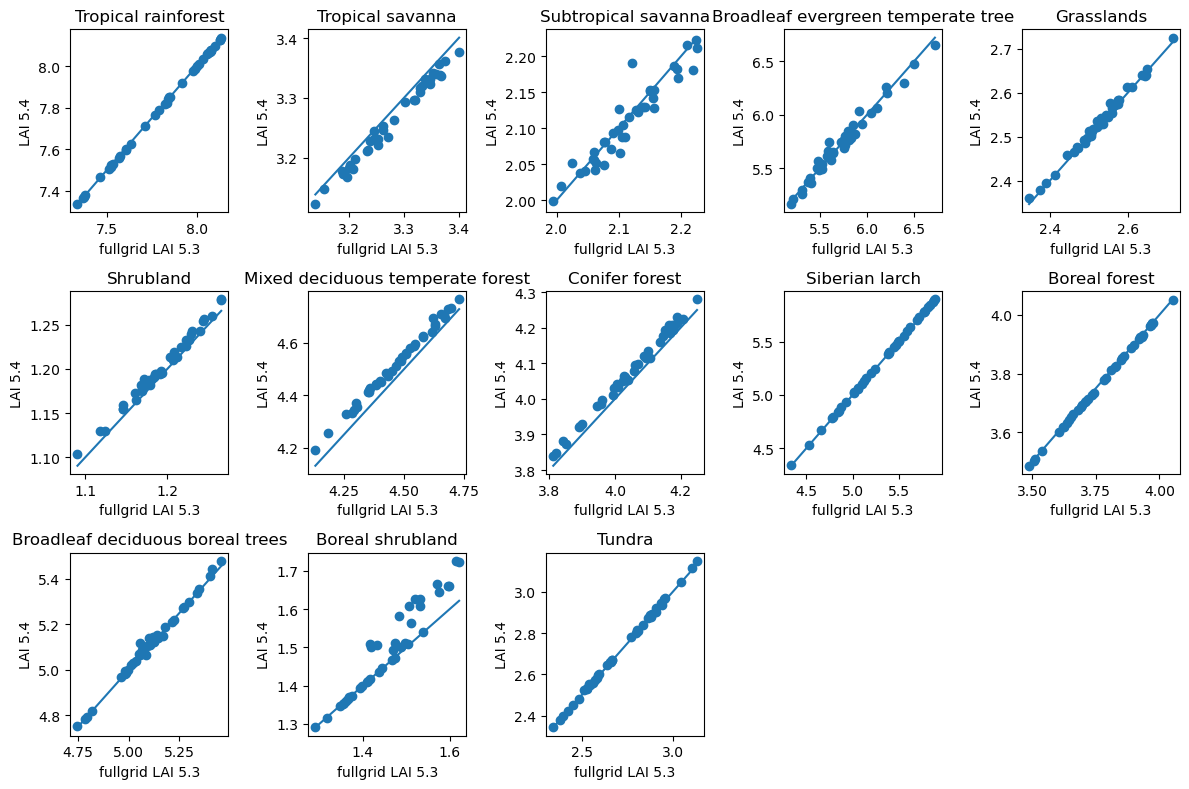

In [126]:
plt.figure(figsize=(12,8))
for i in range(13):
    plt.subplot(3,5,i+1)
    plt.scatter(biome_lai[i],biome_lai_54[i],label='5.4 surfdat')
    #plt.scatter(biome_lai[i],ds_lhc.TLAI_biome_amax.isel(ens=0,biome=i+1),label='sparsegrid')
    plt.plot([min(biome_lai[i]),max(biome_lai[i])],[min(biome_lai[i]),max(biome_lai[i])])
    plt.title(biome_masks.biome_names[i+1].values)
    plt.xlabel('fullgrid LAI 5.3')
    plt.ylabel('LAI 5.4')
    #if i ==0:
    #    plt.legend()
plt.tight_layout()
plt.savefig('fullgrid53_v_fullgrid54.png')

### Map differences

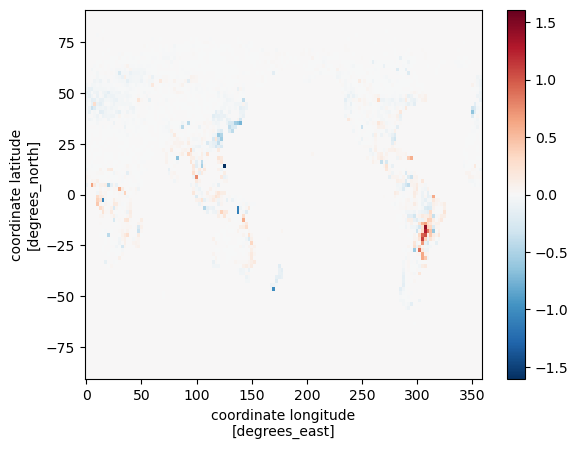

In [20]:
(lai - lai_54).plot()

### PFT differences

In [21]:
#read in the fullgrid data
d='/glade/campaign/cgd/tss/projects/PPE/ctsm53017_f19_BNF_hist_fullgrid/'
files=sorted(glob.glob(d+'*h1*'))[43*12:]
ds_h1=xr.open_mfdataset(files,combine='by_coords',parallel=True)
ds_h1=fix_time(ds_h1)

In [23]:
#helpers
fgmap=xr.open_dataset('pftmean/fgmap.nc').fgmap
tmp=xr.open_dataset('..//utils/lapft_ctsm5.3.012.nc')
lapft=tmp.lapfty
apft=tmp.lafg

In [25]:
#define some groups
g=ds_h1.pfts1d_itype_veg.isel(time=0,pft=fgmap)
g.name='pft'
g1=xr.DataArray(g.values,dims='pft')
g1.name='pft'
pft=ds_h1.pfts1d_itype_veg.isel(time=0)
pft.name='pft'

In [26]:
#read in the fullgrid data
d='/glade/derecho/scratch/wwieder/archive/ctsm53041_54surfdata_PPEbaseline_101_HIST/lnd/hist/'
files=sorted(glob.glob(d+'*h1*'))[43*12:]
ds_54_h1=xr.open_mfdataset(files,combine='by_coords',parallel=True)
ds_54_h1=fix_time(ds_54_h1)

In [42]:
v='TLAI'
tmp = apft.sel(year=slice('1980','2020')).rename({'pftfg':'pft'})
x=amean(ds_h1[v]).sel(year=slice('1980','2020'))
x53=(tmp*x).groupby(pft).sum()/tmp.groupby(pft).sum()
x=amean(ds_54_h1[v]).sel(year=slice('1980','2020'))
x54=(tmp*x).groupby(pft).sum()/tmp.groupby(pft).sum()
plt.figure(figsize=[15,8])
for p in range(1,16):

    a=x53.isel(pft=p)
    b=x54.isel(pft=p)
    
    x1=min(a.min(),b.min())
    x2=max(a.min(),b.max())
    
    xmin=x1-0.05*(x2-x1)
    xmax=x2+0.05*(x2-x1)
    
    plt.subplot(3,5,p)
    plt.plot(a,b,'.')
    plt.title(pfts[p])
    if p%5==1:
        plt.ylabel('5.3 '+v)
    if p>10:
        plt.xlabel('5.4 '+v)
    
    r2=np.round(np.corrcoef(a,b)[0,1]**2,2)
    rmse=round_sig(np.sqrt(np.mean((a-b)**2)).values)
    
    plt.plot([xmin,xmax],[xmin,xmax],':')
    plt.xlim([xmin,xmax])
    plt.ylim([xmin,xmax])
    plt.text(x1,x2-0.06*(x2-x1),'R$^2$: '+str(r2));
    plt.text(x1,x2-0.16*(x2-x1),'RMSE: '+str(rmse));

plt.subplots_adjust(hspace=0.3,wspace=0.2)
#plt.savefig('pftmean/tlai_pftmean.png',dpi=300,bbox_inches='tight')

ValueError: cannot reindex or align along dimension 'pft' because of conflicting dimension sizes: {119442, 117587}

### Sudoku biome mean